<a href="https://colab.research.google.com/github/ahmedtarek-/Deep-Q-Learning/blob/main/deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
  <img style="float: left;"  width="140" src=" 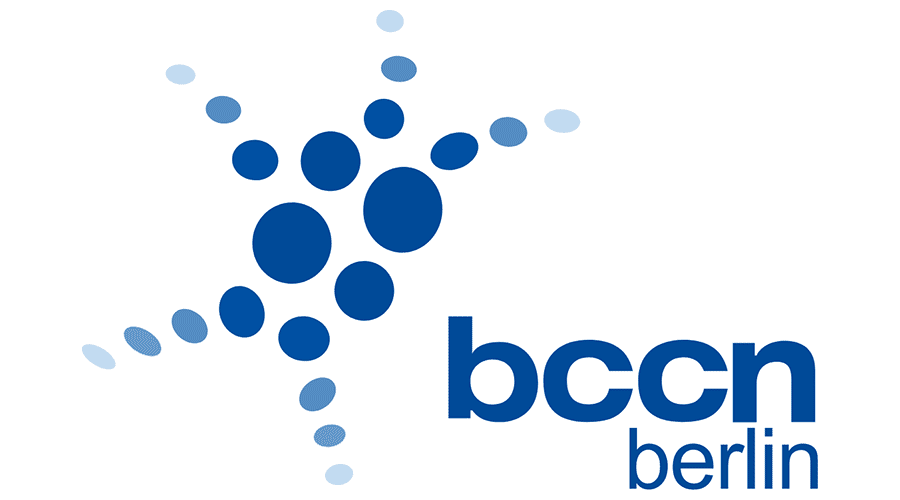">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Models of Higher Brain Functions
        <br>Computer Course
        <br>
    </div>
</h1>
    
---
<div style="text-align: left; float: left">
    Lecturer: Prof. Dr. Henning Sprekeler
</div>

<div style="text-align: right">
    Assistant: Jarek Liesen
    <br>(jarek@bccn-berlin.de)
</div>



# Deep Q-Learning Project (MHBF)

Names: Ahmed Abdalfatah - Arina Belova
Group: "O"

In [26]:
# Cloning the required files from git directly to avoid pain
!rm -rf Deep-Q-Learning
!git clone https://github.com/ahmedtarek-/Deep-Q-Learning.git
!cp -r /content/Deep-Q-Learning/gym-grid/gym_grid gym_grid
!cp /content/Deep-Q-Learning/experience_buffer.py experience_buffer.py

Cloning into 'Deep-Q-Learning'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 75 (delta 36), reused 47 (delta 18), pack-reused 0
Unpacking objects: 100% (75/75), 157.11 KiB | 3.02 MiB/s, done.


In [2]:
# Install required packages
!pip install -q gym==0.15.4
!pip install -q pycolab==1.2
!pip install -q torch==1.2.0
#!pip install -q matplotlib==3.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.12.1 requires cloudpickle>=1.5.0, but you have cloudpickle 1.2.2 which is incompatible.
tensorflow-probability 0.20.1 requires cloudpickle>=1.3, but you have cloudpickle 1.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.7/165.7 kB 2.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.2.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.2.0


In [27]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# Import required packages
import random
from collections import OrderedDict

import gym
import gym_grid

import numpy as np
import matplotlib.pyplot as plt

from experience_buffer import ExperienceBuffer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1 - Environment Implementation

/usr/local/lib/python3.10/dist-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


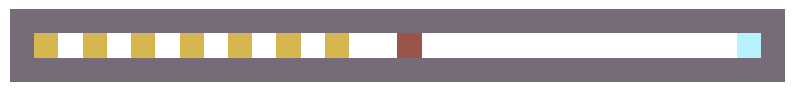

In [ ]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# T-Maze Environment
env = gym.make("LinearTrack-v0")
_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)

# TODO: Deadly Gridworld
# env = gym.make("DeadlyGrid-v0")
# _, obs_to_render = env.reset_with_render()
# env.render(obs_to_render)

200
0


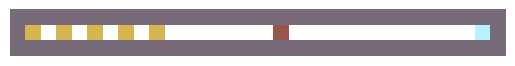

In [ ]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
rew_total = 0
for i in range(50):
    action = env.action_space.sample()
    _, rew , done, _, obs_to_render = env.step_with_render(action)
    env.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)
print(action)

# Part 2 - Deep Q-Learning Agents

In [ ]:
# PLAYGROUND CELL
states = env.observation_space.shape
actions = env.action_space.n

env.observation_space.shape

(3, 32, 4)

## 2.1) Defining Network

In [ ]:
import torch
import torch.nn as nn

np.random.seed(42)
bs = 128

# Simple MLP class

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, dim_input, dim_output):
    super().__init__()

    self.layers = nn.Sequential(OrderedDict([
    ('hidden', nn.Linear(dim_input, 128)),
    ('act', nn.ReLU()),
    ('output', nn.Linear(128, dim_output)),
    # maybe we want this as well ('outact', nn.Sigmoid()),
    ]))

    # init weights, maybe Xavier init?
    self.layers.apply(self.init_weights)

  def init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.xavier_uniform_(module.weight)
      module.bias.data.fill_(0.01)

  def forward(self, x):
      return self.layers(x)

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

model = MLP(states, actions)
model

MLP(
  (layers): Sequential(
    (hidden): Linear(in_features=384, out_features=128, bias=True)
    (act): ReLU()
    (output): Linear(in_features=128, out_features=3, bias=True)
  )
)

## 2.2) Defining policy

In [ ]:
def eps_greedy(q, e=0.2):
  rand = np.random.uniform(0, 1)
  if rand <= (1 - e):
    chosen_action = torch.argmax(q).item()
  else:
    chosen_action = np.random.choice(range(len(q)))

  q_value = q[chosen_action]
  return chosen_action, q_value

## 2.3) Defining Y_hat

In [ ]:
def calculate_y_hat(reward, max_next_q, done, gamma=0.99):
  return torch.Tensor([reward + gamma * (1 - done) * max_next_q.detach().numpy()])

In [ ]:
def rollout_episode(env, model, policy, eval_steps, gamma = 0.99):
    model.eval()
    rew_total = 0
    discounter_reward = 0
    current_state = env.reset()

    for _ in range(eval_steps):
        # use the epsilon greedy policy with a ver small epsilon = 0.01
        q = model(torch.Tensor(current_state.flatten()))
        action, _ = policy(q, e = 0.01)
        new_state, rew , done, _ = env.step(action)
        rew_total += rew
        discounter_reward += rew * gamma
        current_state = torch.Tensor(new_state.flatten())

        if done:
            break

    model.train()
    return rew_total, discounter_reward, done

## 2.4) Defining main loop

In [ ]:
def the_loop(model, env, loss_function, num_update_steps = 20000, num_episodes = 50, policy = eps_greedy, evaluate_steps = 500, discount_factor = 0.1):
  # episodes num = 50/100 and updates = 20000/100000

  rew_inter_arr = np.zeros(int(num_update_steps / evaluate_at))
  discounted_rew_arr = np.zeros(int(num_update_steps / evaluate_at))
  counter = 0
  sample_size = np.prod(env.observation_space.shape)

  state_size = env.reset().flatten().shape[0]
  experience_buffer = ExperienceBuffer((state_size, 1, 1, state_size))

  counter = 0
  while counter < num_update_steps:
    current_state = env.reset()
    print(experience_buffer)

    for _ in range(num_episodes):
      # TODO: another for loop for batches

      # 1. Forward pass on NN to get the Q(t)
      #print(current_state.shape)
      current_state_tensor = torch.Tensor(current_state.flatten())
      q_t = model(current_state_tensor)

      # 2. Decide which action to choose based on annealing epsilon greedy policy
      # TODO: # sigmoid schedule on the epsilon so we have more exploration
      chosen_action, current_q_value = policy(q_t, e = 1 * (1 - ((counter + 1) / num_update_steps)))
      #print(f"Current q value is {current_q_value}")

      # 3. Take action/step and get reward and next state
      next_state, reward , done, _ = env.step(chosen_action)

      # 4. Run another forward pass to get all q_values for next_state
      next_state_tensor = torch.Tensor(next_state.flatten())

      # 5. Store in experence replay buffer:
      experience_buffer.add(current_state_tensor.numpy(), chosen_action, reward, next_state_tensor.numpy())

      # TODO: forgot to update current state, so it was learning a lot from the initial state:
      current_state_tensor = next_state_tensor

      q_next_t = model(next_state_tensor)

      # 6. Get maximum q_value, greedy action
      _, next_max_q_value = policy(q_next_t, e=0)
      #next_max_q_value, q_next_t

      # 7. Calculate Y_hat
      y_hat = calculate_y_hat(reward, next_max_q_value, done * 1).detach()
      #print(f"Do we require grad? {y_hat.requires_grad}")

      # 8. Loss function
      loss = loss_function(current_q_value, y_hat)
      #print(current_q_value.type())
      #print(y_hat.type())

      # 9. Backpropagate to learn
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 10. Check if we terminate an episode due to one of the termination conditions
      if done:
        break

      # 11. TODO: Do the evaluation every 500 steps
      # run in the env under greedy policy to get running reward
      if (counter % evaluate_steps) == 0:
        with torch.no_grad():
          rew_intermediate, disc_rew_intermediate, rollout_done = rollout_episode(current_state_tensor, env, model, policy, discount_factor)
          print(f"Intermediate reward after {counter} update is {rew_intermediate}")
          print(f"Intermediate discounted reward after {counter} update is {disc_rew_intermediate}")
        if rollout_done:
          break

      # step counter
      counter +=1

      # 12. Check if we're out of updating for good.
      if counter >= num_update_steps:
        break

      # YAAAY repeat now


## 2.5) Defining the experience replay data structures

In [30]:
# Example on how to use this mofo?

# A) Initialize with shape tuple (assuming state is represented by 4 values)
exp_buffer = ExperienceBuffer((4,1,1,4,1))

# B) Add some items to the buffer (5 items)
exp_buffer.add(np.array([1,2,3,4]), 1, 2, np.array([1,2,3,90]), 1)
exp_buffer.add(np.array([10,20,30,40]), 1, 0, np.array([1,2,3,90]), 1)
exp_buffer.add(np.array([1000,20,30,4000]), 1, 0, np.array([12,22,32,290]), 1)
exp_buffer.add(np.array([1,2,3,4]), 3, 2, np.array([0,0,0,0]), 1)
exp_buffer.add(np.array([1,1,1,1]), 3, 100, np.array([1,2,3,90]), 1)

# C) Get a batch using a batch_size bigger than number of items (all items)
exp_batch = exp_buffer.get_next()
print(exp_batch.rewards)

# D) Get a batch using a batch_size smaller than number of items (random sample)
exp_batch = exp_buffer.get_next(batch_size=2)
print(exp_batch.rewards)


# E) Get a batch using a batch_size 1 (get last item)
exp_batch = exp_buffer.get_next(batch_size=1)
print(exp_batch.rewards)

# F) Just printing the buffer stats
print(exp_buffer)

[[  2.]
 [  0.]
 [  0.]
 [  2.]
 [100.]]
[[100.]
 [  0.]]
[[100.]]

      Capacity: 1000
      Size: 5
      Current Index: 5
      Shape: (4,1,1,4)
    


Redifining the loop to work with XP-replay

In [25]:
def the_loop_zwei(model, env, loss_function, num_update_steps = 20000, num_episodes = 50, policy = eps_greedy, evaluate_steps = 500, discount_factor = 0.1):
  # episodes num = 50/100 and updates = 20000/100000

  rew_inter_arr = np.zeros(int(num_update_steps / evaluate_at))
  discounted_rew_arr = np.zeros(int(num_update_steps / evaluate_at))
  counter = 0
  sample_size = np.prod(env.observation_space.shape)

  state_size = env.reset().flatten().shape[0]
  experience_buffer = ExperienceBuffer((state_size, 1, 1, state_size))

  counter = 0
  while counter < num_update_steps:
    current_state = env.reset()
    print(experience_buffer)

    for _ in range(num_episodes):
      ######################################################
      ### A) Chosing action and moving through env phase ###
      ######################################################

      # 1. Forward pass on NN to get the Q(t)
      #print(current_state.shape)
      current_state_tensor = torch.Tensor(current_state.flatten())
      q_t = model(current_state_tensor)

      # 2. Decide which action to choose based on annealing epsilon greedy policy
      chosen_action, current_q_value = policy(q_t, e = 1 * (1 - ((counter + 1) / num_update_steps)))

      # 3. Take action/step and get reward and next state
      next_state, reward , done, _ = env.step(chosen_action)

      # 4. Store in experence replay buffer
      experience_buffer.add(current_state_tensor.numpy(), chosen_action, reward, next_state_tensor.numpy())

      #########################
      ### B) Training Phase ###
      #########################

      # 5. Get a sample from the buffer to use for updating the network
      exp_batch = experience_buffer.get_next(batch_size = batch_size)

      # 6. Run another forward pass to get the q_values
      current_q_values = model(exp_batch.get_current_states())
      next_q_values = model(exp_batch.get_next_states())

      # 7. Get maximum q_value, greedy action
      _, next_max_q_value = policy(next_q_values, e=0)

      # 8. Calculate Y_hat
      y_hat = calculate_y_hat(exp_batch.get_rewards(), next_max_q_value, exp_batch.get_done() * 1).detach()

      # 9. Loss function
      loss = loss_function(current_q_values, y_hat)

      # 10. Backpropagate to learn
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 11. Update current state USING the next_state from phase (A), not related
      # to the training efforts in this phase
      current_state_tensor = torch.Tensor(next_state.flatten())

      # 12. Check if we terminate an episode due to one of the termination conditions
      if done:
        break

      # 13. TODO: Do the evaluation every 500 steps
      # run in the env under greedy policy to get running reward
      if (counter % evaluate_steps) == 0:
        with torch.no_grad():
          rew_intermediate, disc_rew_intermediate, rollout_done = rollout_episode(current_state_tensor, env, model, policy, discount_factor)
          print(f"Intermediate reward after {counter} update is {rew_intermediate}")
          print(f"Intermediate discounted reward after {counter} update is {disc_rew_intermediate}")
        if rollout_done:
          break

      # step counter
      counter +=1

      # 14. Check if we're out of updating for good.
      if counter >= num_update_steps:
        break

      # YAAAY repeat now


(array([12,  9,  5, 16]), array([11,  5,  1,  4]))

# Part 3 - Testing with environments

## 3.1) Linear track environment

In [ ]:
env = gym.make("LinearTrack-v0")

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

lr = 0.001
model = MLP(states, actions)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

the_loop(model, env, loss_func)


      Capacity: 1000
      Size: 0
      Current Index: 0
      Shape: (384,1,1,384)
    
Inside rollout
Intermediate reward after 0 update is 0
Intermediate discounted reward after 0 update is 0.0

      Capacity: 1000
      Size: 39
      Current Index: 39
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 88
      Current Index: 88
      Shape: (384,1,1,384)
    


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



      Capacity: 1000
      Size: 137
      Current Index: 137
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 186
      Current Index: 186
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 235
      Current Index: 235
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 284
      Current Index: 284
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 333
      Current Index: 333
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 382
      Current Index: 382
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 431
      Current Index: 431
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: 480
      Current Index: 480
      Shape: (384,1,1,384)
    
Inside rollout
Intermediate reward after 500 update is 0
Intermediate discounted reward after 500 update is 0.0

      Capacity: 1000
      Size: 519
      Current Index: 519
      Shape: (384,1,1,384)
    

      Capacity: 1000
      Size: